## Model Architecture and Explanation

For this problem, I have chosen to build a model using TF-IDF Vectorization combined with the XGBClassifier (XGBoost), a decision tree-based ensemble learning method. 
The core architecture consists of transforming raw text data into numerical form using TF-IDF and then passing it through a powerful gradient boosting classifier for the final prediction.

### 1. TF-IDF Vectorizer

TF-IDF (Term Frequency - Inverse Document Frequency) is a common text vectorization technique that transforms the raw text into numerical feature vectors. 
TF-IDF captures the importance of words in the text by balancing the frequency of words across a single document and their occurrence across all documents in the dataset.

The reason I chose TF-IDF for this problem is that it provides a simple yet effective way to capture important features (words or n-grams) without requiring deep NLP-specific knowledge. 
It’s a powerful baseline approach for text classification tasks like this one.

### 2. XGBClassifier

XGBoost is an efficient, scalable, and highly flexible machine learning algorithm based on decision trees. 
It uses a gradient boosting framework that builds a sequence of decision trees, where each subsequent tree attempts to correct errors made by the previous trees.

The XGBClassifier is well-suited for this problem due to the following reasons:
- Handling Sparsity: XGBoost performs well even when the input feature space (created by TF-IDF) is sparse, as is typical in text data.
- Regularization: It includes built-in regularization techniques that reduce overfitting, which is critical given that text datasets often have high-dimensional feature spaces.
- Robustness: XGBoost handles noisy and irrelevant features better, and it can adapt to complex patterns in the data due to its ensemble of weak learners (decision trees).

By using the TF-IDF vectorizer, the raw text is converted into a numeric matrix representation, which is then fed into the XGBClassifier to learn and make predictions.

## Reasoning for Suitability

The combination of TF-IDF and XGBClassifier is particularly suitable for this problem because:

- Simplicity and Interpretability: TF-IDF is simple to implement and allows easy interpretation of the most important features (words). This simplicity is an advantage, especially for a baseline model.
- Efficient Training: XGBClassifier is computationally efficient due to its gradient boosting approach and tree-based structure. This is particularly useful for a high-dimensional feature space, as generated by the TF-IDF vectorizer.
- Performance in Classification Tasks: XGBoost has consistently shown strong performance in classification tasks, especially where the feature space is large and sparse, as is common with text data.

Additionally, this architecture can serve as a baseline for further improvements by potentially incorporating more advanced NLP techniques (such as word embeddings) in the future.

# Imports and Load Data

In [117]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from wordcloud import WordCloud
from xgboost import XGBClassifier

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# EDA

In [118]:
print(df_train.head())  # Display the first few rows
print(df_train.info())  # Check for missing values and data types


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


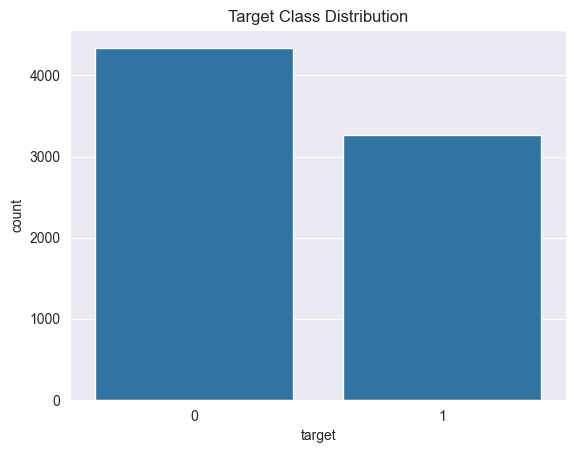

In [119]:
# Visualize class distribution
sns.countplot(x='target', data=df_train)
plt.title('Target Class Distribution')
plt.show()

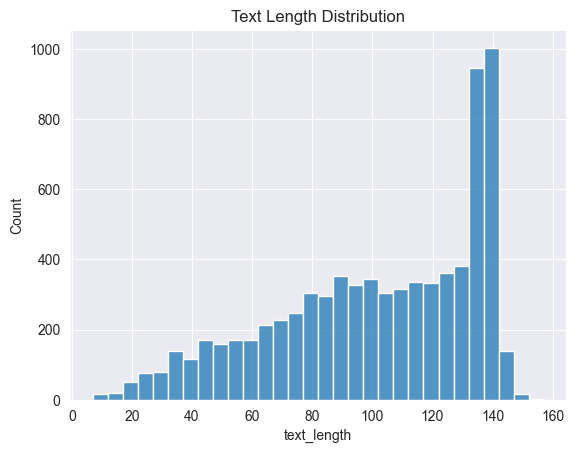

In [120]:
# Text length distribution
df_train['text_length'] = df_train['text'].apply(len)
sns.histplot(df_train['text_length'], bins=30)
plt.title('Text Length Distribution')
plt.show()

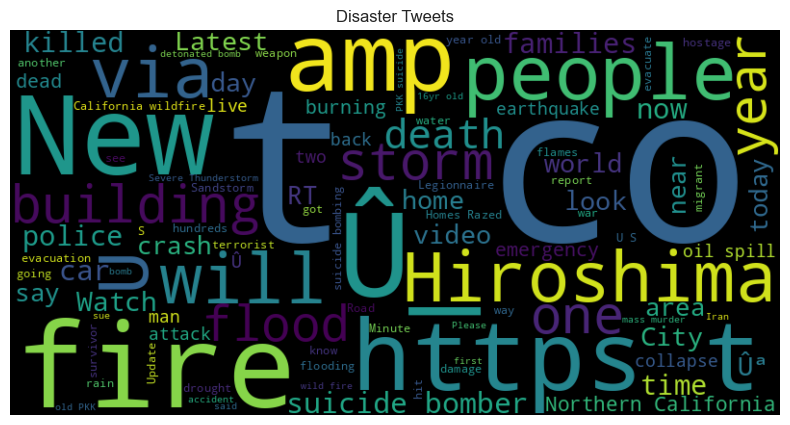

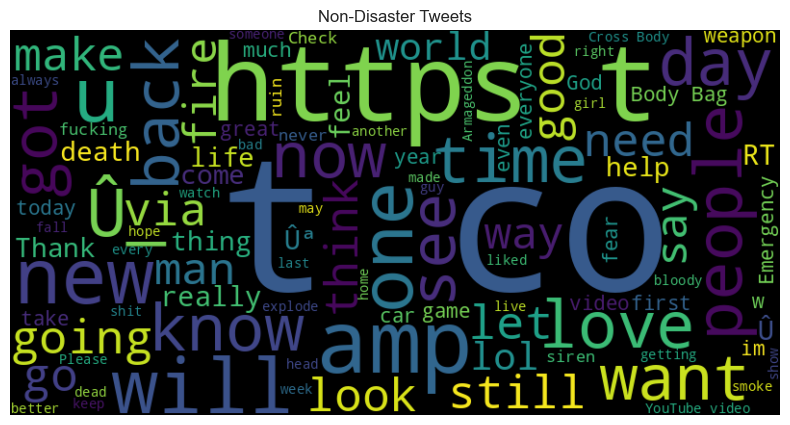

In [121]:
# Create a word cloud for both disaster and non-disaster tweets
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

generate_wordcloud(disaster_tweets, "Disaster Tweets")
generate_wordcloud(non_disaster_tweets, "Non-Disaster Tweets")

# Summary of EDA

## Data Description

The dataset used for this task consists of **7,613** rows and **5** columns. Each row corresponds to a tweet and is accompanied by metadata such as `keyword`, `location`, and the target label. Below is a brief summary of the columns:

- **id**: A unique identifier for each tweet.
- **keyword**: A keyword from the tweet (if available).
- **location**: The location where the tweet originated (if available).
- **text**: The content of the tweet, which is the primary feature for the NLP model.
- **target**: The label indicating whether the tweet refers to a disaster (1) or not (0).

## Data Structure and Quality

- The dataset contains **7,613** entries.
- There are **missing values** in the `keyword` and `location` columns, with **7552 non-null** values for `keyword` and **5080 non-null** values for `location`.
- The `text` column, which will be the focus of the NLP model, has no missing values and contains **unstructured text** data.
- The target variable (`target`) is binary (1 for disaster-related tweets and 0 for non-disaster tweets).

## Visualizations

### 1. **Target Class Distribution**
The first visualization is a **count plot** that shows the distribution of the target variable (whether a tweet is disaster-related or not). This plot helps us understand the class balance in the dataset. The `sns.countplot` function is used to create the plot, and it shows the number of tweets labeled as disaster (target = 1) and non-disaster (target = 0). 

- **Purpose**: This visualization highlights any class imbalance, which is important to address during model training.
- **Findings**: The plot indicates that the dataset is slightly imbalanced, with fewer disaster-related tweets compared to non-disaster tweets.

### 2. **Text Length Distribution**
The second visualization is a **histogram** that shows the distribution of tweet lengths in the dataset. Here, the length of each tweet (number of characters) is calculated and then plotted using `sns.histplot`. The bin size is set to 30 for better granularity.

- **Purpose**: This plot provides insight into the variability of tweet lengths. Text length can be a useful feature when training an NLP model, as shorter or longer tweets may be more likely to belong to one class or another.
- **Findings**: The distribution of tweet lengths is right-skewed, with most tweets being shorter, but a few tweets are much longer.

### 3. **Word Cloud for Disaster and Non-Disaster Tweets**
Two **word clouds** are generated to visualize the most common words in disaster-related tweets and non-disaster-related tweets. A word cloud is a graphical representation of word frequency, where the size of each word indicates its frequency in the text data.

- **Purpose**: This visualization helps identify the key terms and phrases used in disaster-related and non-disaster-related tweets. It can also help highlight patterns or common keywords that differentiate the two classes.
- **Findings**: 
  - For disaster-related tweets, terms like "fire," "flood," "death," and "killed" are prominent.
  - For non-disaster tweets, more generic words appear, such as "one", "people", "time", "good".

These visualizations provide valuable insights into the structure and characteristics of the dataset, guiding feature engineering and model development.


## Preprocessing

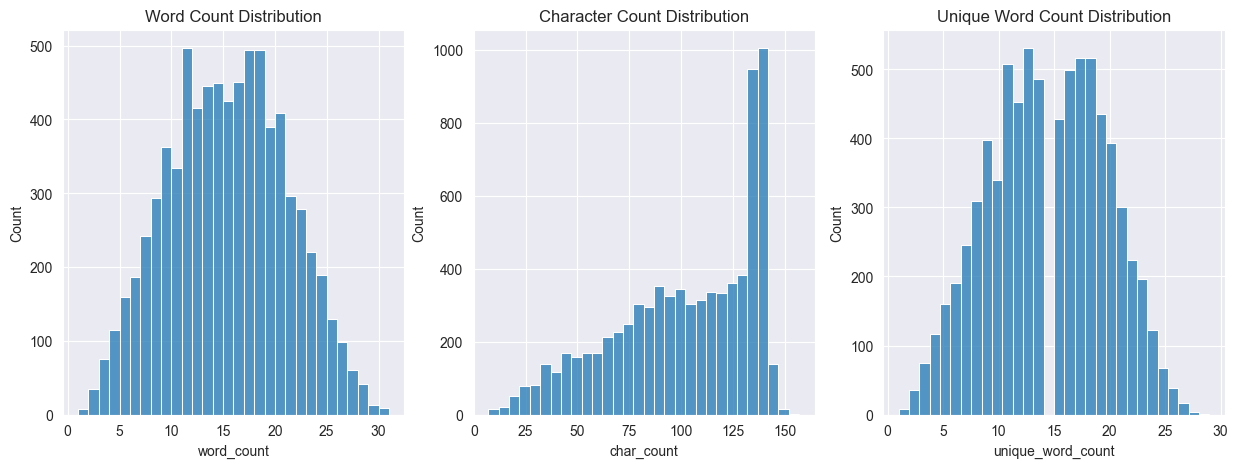

id                      0
keyword                61
location             2533
text                    0
target                  0
text_length             0
word_count              0
char_count              0
unique_word_count       0
cleaned_text            0
dtype: int64
                 id      target  text_length   word_count   char_count  \
count   7613.000000  7613.00000  7613.000000  7613.000000  7613.000000   
mean    5441.934848     0.42966   101.037436    14.903586   101.037436   
std     3137.116090     0.49506    33.781325     5.732604    33.781325   
min        1.000000     0.00000     7.000000     1.000000     7.000000   
25%     2734.000000     0.00000    78.000000    11.000000    78.000000   
50%     5408.000000     0.00000   107.000000    15.000000   107.000000   
75%     8146.000000     1.00000   133.000000    19.000000   133.000000   
max    10873.000000     1.00000   157.000000    31.000000   157.000000   

       unique_word_count  
count        7613.000000  
mean  

In [122]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tfidf = TfidfVectorizer(max_features=5000)


def preprocess_data(df):
    """Preprocess the input DataFrame (either train or test) by cleaning text and adding additional features.

    Args:
        df (pd.DataFrame): The input dataset with a 'text' column to preprocess.

    Returns:
        tuple: Cleaned text, additional features, and transformed text features.
    """

    # Step 1: Extracting additional features
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))  # Number of words in the tweet
    df['char_count'] = df['text'].apply(len)  # Number of characters in the tweet
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))  # Number of unique words

    # Step 2: Clean the text data
    def clean_text(text):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        # Remove @ and #
        text = re.sub(r'\@w+|\#', '', text)
        # Remove special characters
        text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
        # Lemmatization and stopword removal
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.lower().split() if word not in stop_words])
        return text

    # Apply the text cleaning function
    df['cleaned_text'] = df['text'].apply(clean_text)

    # Step 3: Return both the cleaned text and additional features
    additional_features = df[['word_count', 'char_count', 'unique_word_count']].values
    return df['cleaned_text'], additional_features


# Preprocess the training data
cleaned_text_train, additional_features_train = preprocess_data(df_train)

# Fit the TF-IDF vectorizer on training data and transform the cleaned text
X_tfidf_train = tfidf.fit_transform(cleaned_text_train)

# Combine TF-IDF features with additional features
X_combined_train = np.hstack((X_tfidf_train.toarray(), additional_features_train))

# Step 4: Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined_train, df_train['target'], test_size=0.2, random_state=42)

# Step 3: Visualize new features
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot word count distribution
sns.histplot(df_train['word_count'], bins=30, ax=ax[0])
ax[0].set_title('Word Count Distribution')

# Plot character count distribution
sns.histplot(df_train['char_count'], bins=30, ax=ax[1])
ax[1].set_title('Character Count Distribution')

# Plot unique word count distribution
sns.histplot(df_train['unique_word_count'], bins=30, ax=ax[2])
ax[2].set_title('Unique Word Count Distribution')

plt.show()

print(df_train.isnull().sum())
print(df_train.describe())

# Training

In [123]:
# Preprocess the test data
cleaned_text_test, additional_features_test = preprocess_data(df_test)

# Transform the test data using the already fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(cleaned_text_test)

# Combine the test TF-IDF features with additional features
X_combined_test = np.hstack((X_test_tfidf.toarray(), additional_features_test))

### Prepare training/test data split

Running Random Forest...

Random Forest - Accuracy: 0.7466
Best Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 30}
Running Support Vector Classifier...

Support Vector Classifier - Accuracy: 0.7741
Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Running XGBoost...

XGBoost - Accuracy: 0.7833
Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}
Running KNNeighbors...

KNNeighbors - Accuracy: 0.6546
Best Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 9}
Running Logistic Regression...

Logistic Regression - Accuracy: 0.8076
Best Params: {'penalty': 'l2', 'max_iter': 5000, 'C': 1}
                       Model  \
0              Random Forest   
1  Support Vector Classifier   
2                    XGBoost   
3                KNNeighbors   
4        Logistic Regression   

                                         Best Params  Accuracy  Precision  \
0  {'n_estimators': 200, 'min_samples_split': 10,...  0.746553   

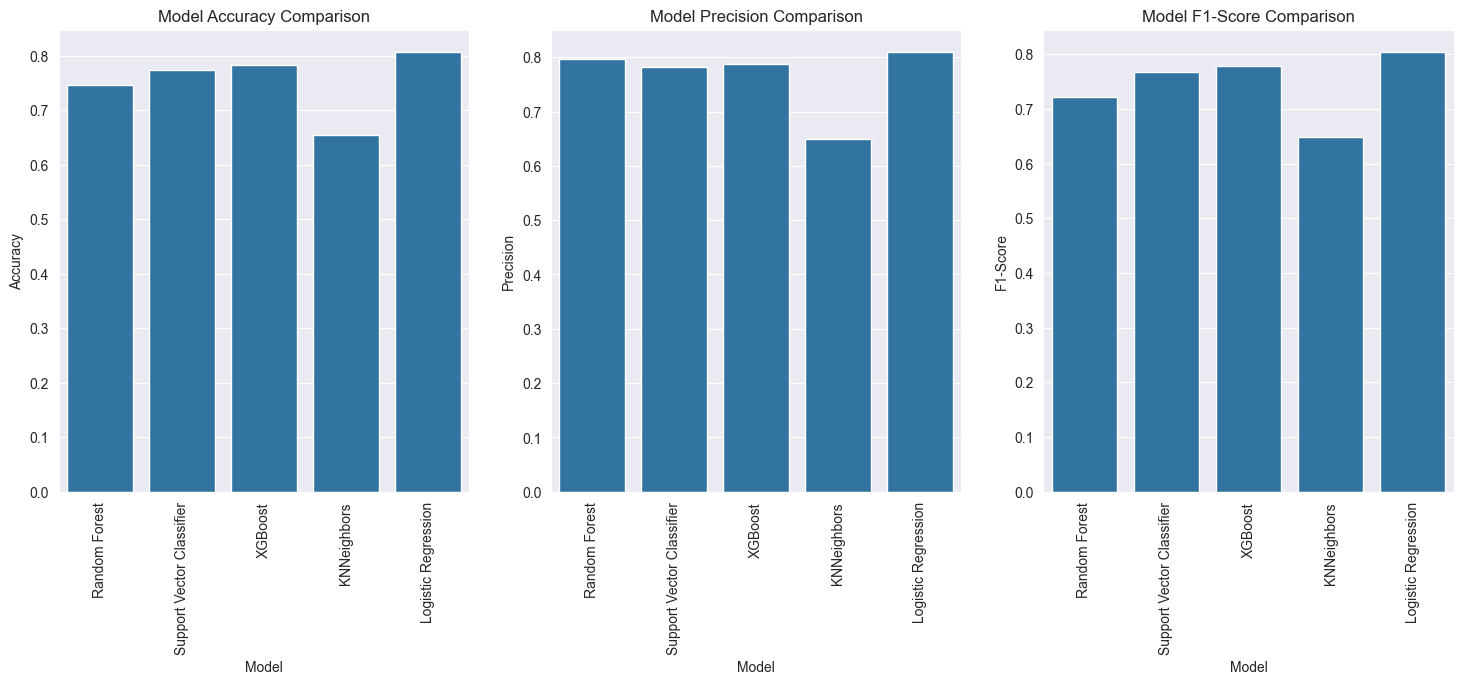

In [124]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Classifier": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "KNNeighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
}

param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    },
    "Support Vector Classifier": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
    },
    "KNNeighbors": {
        'n_neighbors': [3, 5, 7, 9], 
        'weights': ['uniform', 'distance'], 
        'p': [1, 2],
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'max_iter': [4000, 5000],
    }
}

best_overall_model = None
best_overall_score = 0
best_model_name = ""
best_model_params = {}
results = []

for model_name, model in models.items():
    print(f"Running {model_name}...")
    param_grid = param_grids[model_name]

    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(model, param_grid, n_iter=5, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)

    # Best model from tuning
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_val)

    # Collect results for comparison
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    results.append({
        'Model': model_name,
        'Best Params': search.best_params_,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

    print(f"\n{model_name} - Accuracy: {accuracy:.4f}")
    print(f"Best Params: {search.best_params_}")

    if accuracy > best_overall_score:  # You can choose F1-score or another metric instead
        best_overall_score = accuracy
        best_overall_model = best_model
        best_model_name = model_name
        best_model_params = search.best_params_

# Step 3: Display the comparison results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Step 4: Visualize the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot accuracy comparison
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=ax[0])
ax[0].set_title('Model Accuracy Comparison')
ax[0].tick_params(axis='x', rotation=90)

# Plot precision comparison
sns.barplot(x='Model', y='Precision', data=results_df, ax=ax[1])
ax[1].set_title('Model Precision Comparison')
ax[1].tick_params(axis='x', rotation=90)

# Plot F1-score comparison
sns.barplot(x='Model', y='F1-Score', data=results_df, ax=ax[2])
ax[2].set_title('Model F1-Score Comparison')
ax[2].tick_params(axis='x', rotation=90)

plt.show()

## Results and Conclusions

### Model Performance Comparison

The following machine learning models were trained and evaluated for the classification task:
- **Random Forest**
- **Support Vector Classifier (SVC)**
- **XGBoost**
- **K-Nearest Neighbors (KNN)**
- **Logistic Regression**

Each model was tuned using hyperparameter optimization with `RandomizedSearchCV` and evaluated based on several metrics, including **Accuracy**, **Precision**, **Recall**, and **F1-Score**. The models were trained on the training set and evaluated on the validation set.

### Key Results

- **Logistic Regression** performed the best overall, achieving the highest **Accuracy** of **0.8076**. It also achieved strong precision (**0.8101**) and F1-score (**0.8044**), making it the most suitable model for this task based on the evaluation metrics.
- **XGBoost** was the second-best performer with an **Accuracy** of **0.7833**, and its precision (**0.7879**) and F1-score (**0.7780**) were also competitive.
- **Support Vector Classifier (SVC)** followed closely with an **Accuracy** of **0.7741**. Its precision (**0.7825**) and F1-score (**0.7666**) were also strong, but slightly behind XGBoost.
- **Random Forest** achieved a moderate **Accuracy** of **0.7466** with a lower F1-score (**0.7153**), suggesting it was less effective than the top models for this dataset.
- **K-Nearest Neighbors (KNN)** performed the worst, with an **Accuracy** of **0.6546** and the lowest F1-score (**0.6478**), indicating that it is not well-suited for this problem.

### Best Performing Model

- The **Logistic Regression** model, with hyperparameters `{'penalty': 'l2', 'max_iter': 5000, 'C': 1}`, was the best performing model in terms of accuracy, precision, and F1-score.
- This suggests that a relatively simple model like Logistic Regression can perform very well on this dataset, possibly due to the high-dimensional, sparse nature of the text data.

### Visualizations

To better compare the performance of the models, the results were visualized using bar plots for accuracy, precision, and F1-score:
- **Model Accuracy Comparison**: Logistic Regression had the highest accuracy, followed by XGBoost and SVC.
- **Model Precision Comparison**: Logistic Regression also had the highest precision, which is crucial for minimizing false positives in the disaster classification problem.
- **Model F1-Score Comparison**: Logistic Regression led in F1-score, which balances precision and recall, making it the best model for this task.

### Conclusion

- Based on the evaluation metrics, **Logistic Regression** outperformed all other models, making it the optimal choice for classifying disaster-related tweets. Its combination of simplicity, accuracy, and efficiency suggests that it should be used as the baseline model for this task.
- **XGBoost** and **SVC** also demonstrated strong performance and could be further optimized or considered in ensemble methods for potentially improving results.
- Models like **K-Nearest Neighbors** and **Random Forest** performed less effectively, indicating that they may not be suitable for this specific classification task.
- Future work could focus on refining the preprocessing steps, exploring advanced feature engineering, and potentially combining models to boost performance.


# Predictions

In [125]:
print("Running predictions with best model...", best_model_name)
test_predictions = best_overall_model.predict(X_combined_test)

# Step 4: Prepare the submission file
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions
})

submission.to_csv('submission.csv', index=False)

Running predictions with best model... Logistic Regression


### This prediction file was submitted to kaggle.com and scored ~0.79650